<a href="https://colab.research.google.com/github/SRARNAB7/HDS_5320_Group_Project/blob/main/Autism_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the Dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # To work with the categorical Features in the dataset
from imblearn.over_sampling import SMOTE # To do sampling when required for class imbalace
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV # Used CV serach since Grid search can take more time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle # For saving the Models

**Data Loading and Understanding**

In [3]:
#Reading the CSV file
df = pd.read_csv("/content/train.csv")

In [5]:
df.shape

(800, 22)

In [6]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [7]:
df.tail()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
795,796,0,1,0,0,0,0,0,0,1,1,16.597187,m,Hispanic,no,no,New Zealand,no,12.999501,18 and more,Self,0
796,797,0,1,1,0,0,1,0,1,1,1,20.703001,m,White-European,no,no,Cyprus,no,13.561518,18 and more,Self,0
797,798,0,0,0,0,0,0,0,0,0,0,5.711481,m,South Asian,yes,no,New Zealand,no,2.653177,18 and more,Self,0
798,799,0,0,0,0,0,0,0,0,0,0,16.414305,f,?,no,no,Canada,no,9.069342,18 and more,Self,0
799,800,0,1,0,0,0,0,0,0,0,0,46.966113,f,?,no,no,United Arab Emirates,yes,2.243304,18 and more,Self,0


In [9]:
#display all the columns in the dataframe
pd.set_option('display.max_columns', None)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [11]:
#convert Age column to int
df["age"] = df["age"].astype(int)

In [12]:
for col in df.columns:
  numerical_features = ["ID", "age", "result"]
  if col not in numerical_features:
    print(col, df[col].unique())
    print("_"*50)

A1_Score [1 0]
__________________________________________________
A2_Score [0 1]
__________________________________________________
A3_Score [1 0]
__________________________________________________
A4_Score [0 1]
__________________________________________________
A5_Score [1 0]
__________________________________________________
A6_Score [0 1]
__________________________________________________
A7_Score [1 0]
__________________________________________________
A8_Score [0 1]
__________________________________________________
A9_Score [1 0]
__________________________________________________
A10_Score [1 0]
__________________________________________________
gender ['f' 'm']
__________________________________________________
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
__________________________________________________
jaundice ['no' 'yes']
__________________________________________________
austim

In [13]:
#dropping ID and age_desc columns
df = df.drop(columns = ['ID',"age_desc"])

In [14]:
df.shape

(800, 20)

In [ ]:
df.columns

In [16]:
#define the mapping dictionary for country names

mapping = {
    "Viet Nam" : "Vietnam",
    "AmericanSamoa" : "United States",
    "Hong Kong" : "China"
}

df["contry_of_res"] = df["contry_of_res"].replace(mapping)

In [17]:
#Target Class Distribution
df["Class/ASD"].value_counts()

,count
Class/ASD,
0,639
1,161


**Insights into the dataset**

1) Missing values in Ethincity and Relation
2) age_desc column ahs only one unique value. So it is removed as it is not important for prediction
3) fixed country_names
4) Identified Class Imbalance in the Target column

**Exploratory Data Analysis**

In [18]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,27.963750,8.537303,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.329827,4.807676,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-6.137748,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.306575,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,9.605299,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.250000,12.514484,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,15.853126,1.000000


**Univariate Analysis**

Numerical Columns Age, result


In [19]:
#Set the desired theme
sns.set_theme(style = "darkgrid")

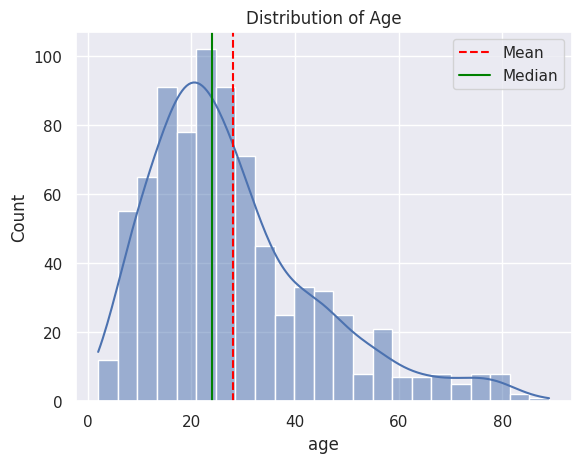

In [22]:
#Histogram for Age
sns.histplot(df["age"], kde = True)
plt.title("Distribution of Age")

#Calculate Mean and Median
age_mean = df["age"].mean()
age_median = df["age"].median()

# print("Mean:", age_mean)
# print("Median", age_median)
# add vertical lines for mean and median
plt.axvline(age_mean, color = "red", linestyle = "--", label = "Mean")
plt.axvline(age_median, color= "green", linestyle = "-", label = "Median")
plt.legend()
plt.show()

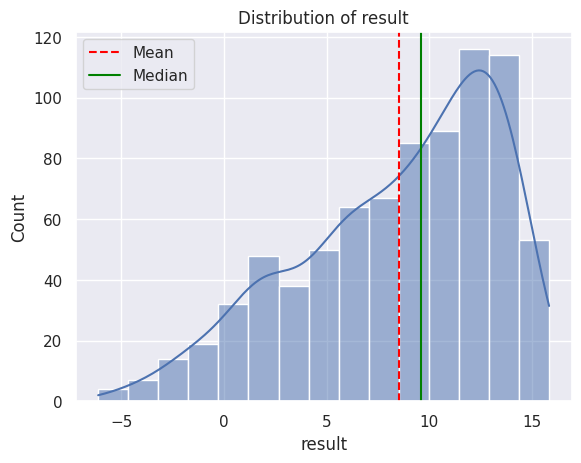

In [23]:
#Histogram for result
sns.histplot(df["result"], kde = True)
plt.title("Distribution of result")

#Calculate Mean and Median
result_mean = df["result"].mean()
result_median = df["result"].median()

# print("Mean:", age_mean)
# print("Median", age_median)
# add vertical lines for mean and median
plt.axvline(result_mean, color = "red", linestyle = "--", label = "Mean")
plt.axvline(result_median, color= "green", linestyle = "-", label = "Median")
plt.legend()
plt.show()

**Boxplot for identifying outliers in the Numerical features**

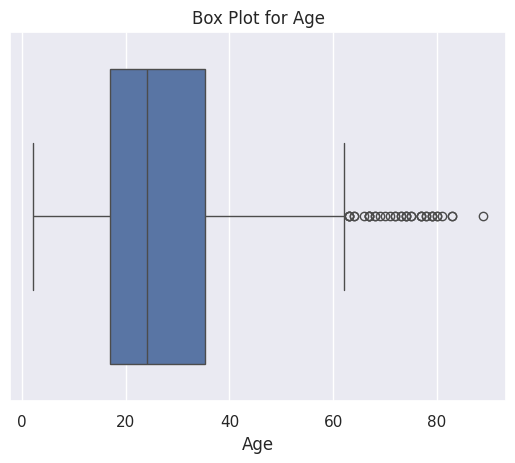

In [24]:
#Box Plot
sns.boxplot(x=df["age"])
plt.title("Box Plot for Age")
plt.xlabel("Age")
plt.show()

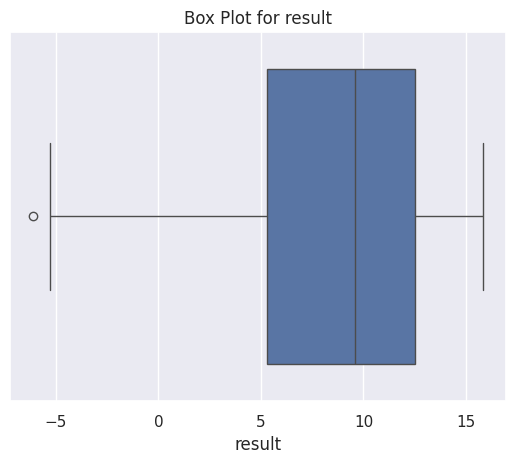

In [25]:
#Box Plot
sns.boxplot(x=df["result"])
plt.title("Box Plot for result")
plt.xlabel("result")
plt.show()

In [27]:
#Count the Outliers in Age using the IQR method
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)

IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

age_outliers = df[(df['age'] < lower_bound) | (df["age"] > upper_bound)]


In [28]:
len(age_outliers)

39

In [30]:
#Count the Outliers in Result using the IQR method
Q1 = df["result"].quantile(0.25)
Q3 = df["result"].quantile(0.75)

IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

result_outliers = df[(df['result'] < lower_bound) | (df["result"] > upper_bound)]

In [31]:
len(result_outliers)

1

**Univariate Analyis of Categorical columns**

In [32]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

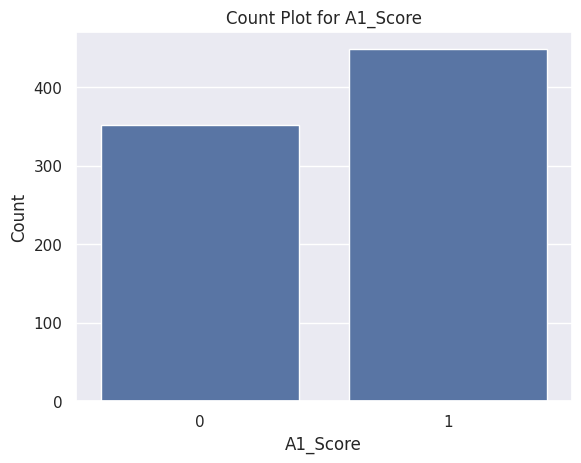

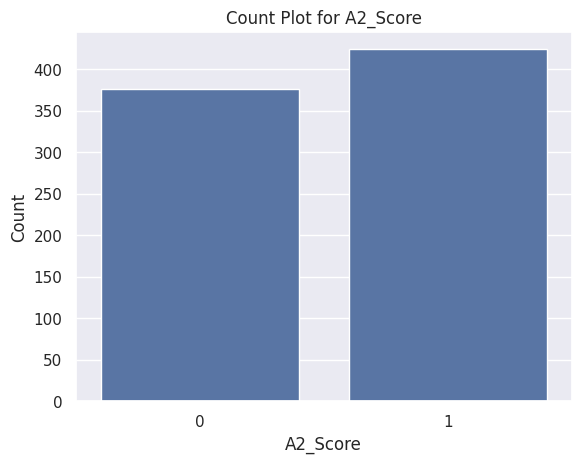

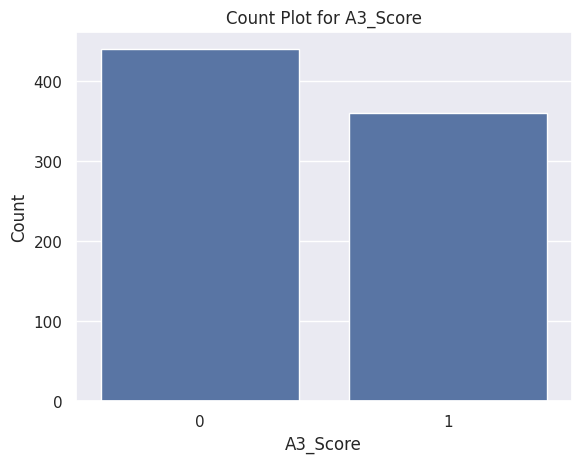

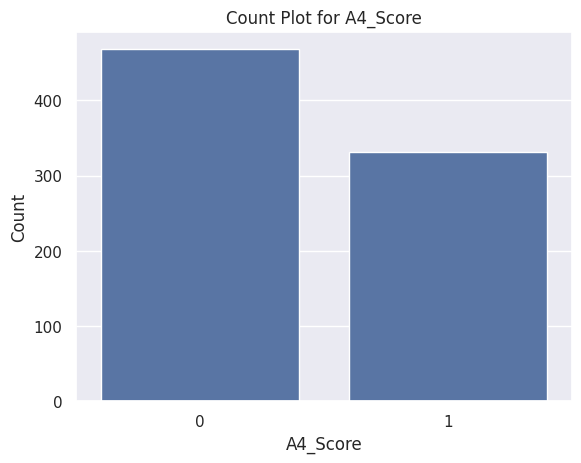

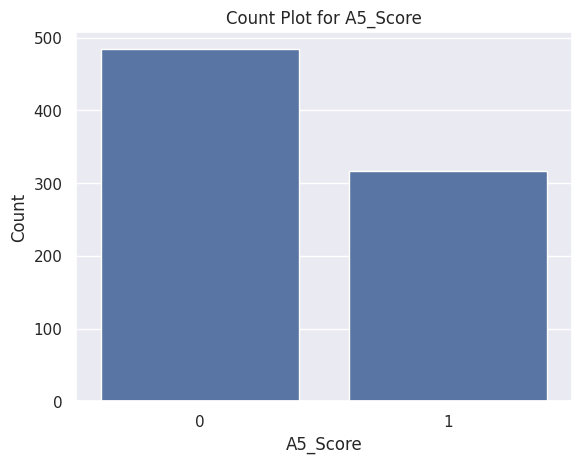

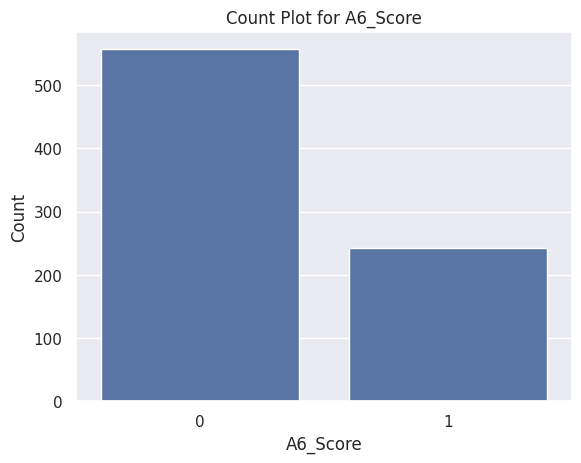

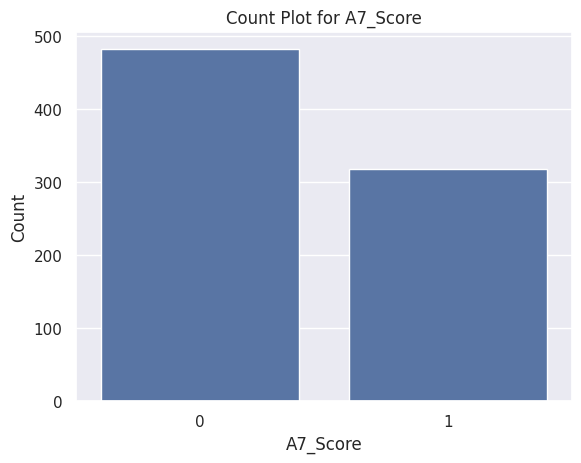

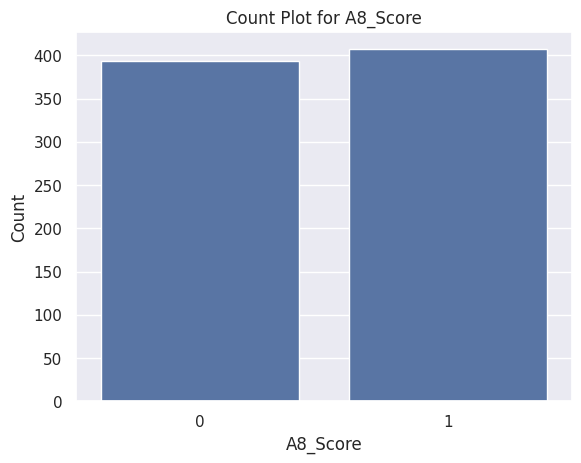

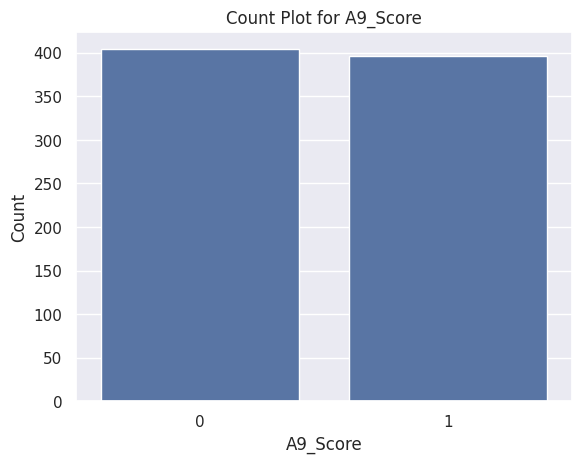

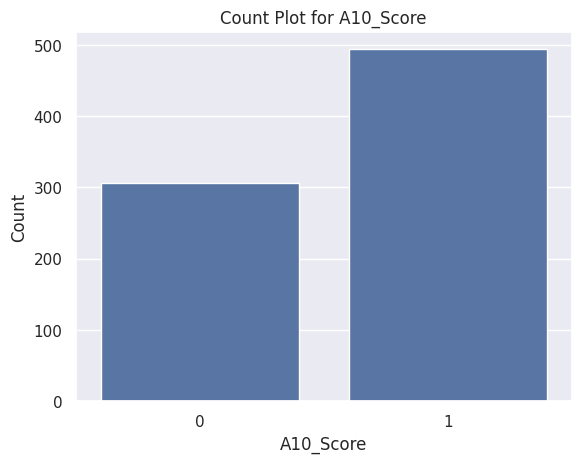

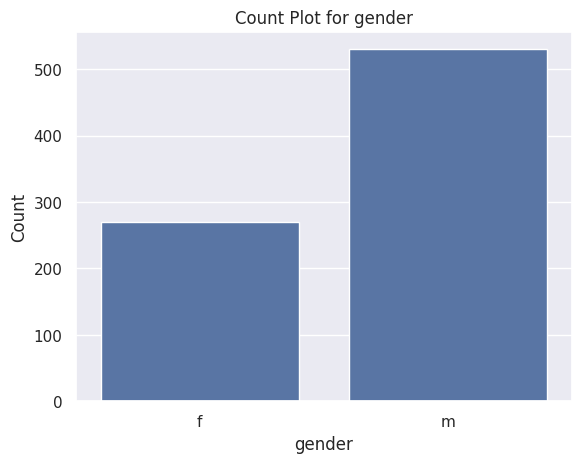

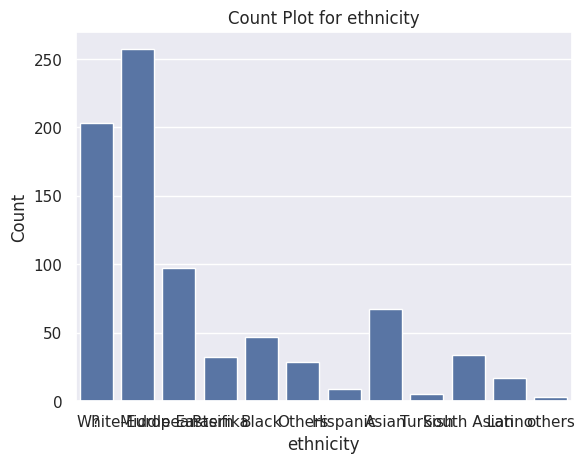

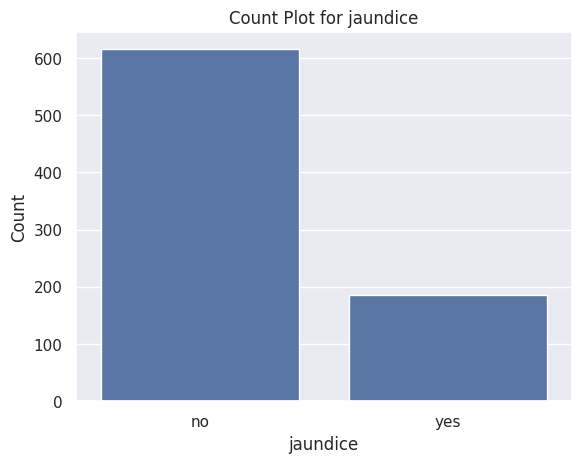

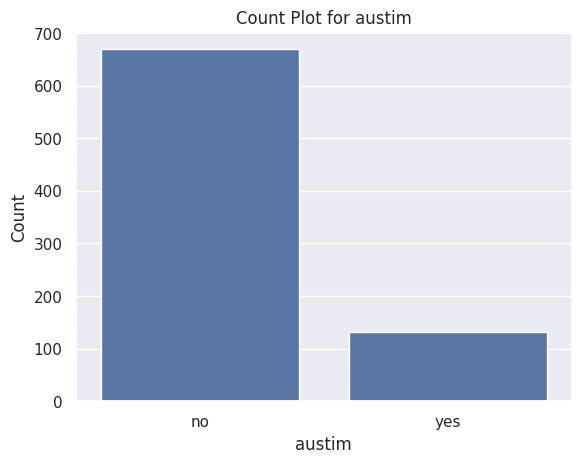

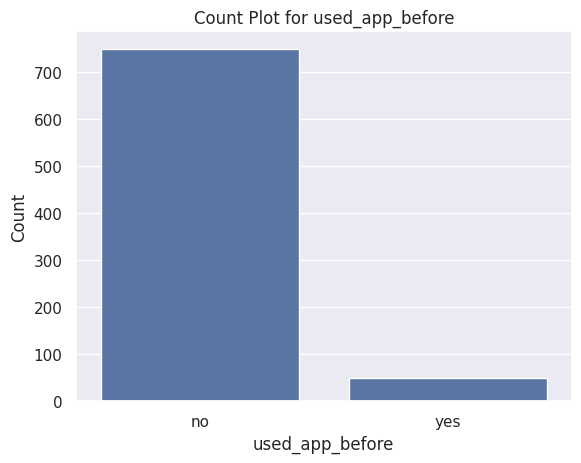

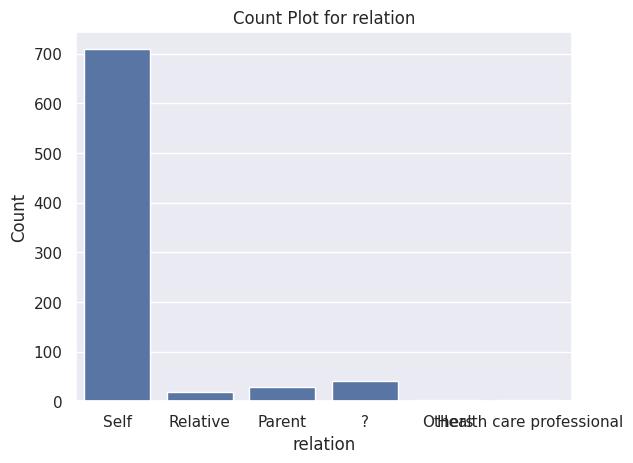

In [34]:
categorical_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender',
       'ethnicity', 'jaundice', 'austim', 'used_app_before',
       'relation' ]

for col in categorical_columns:
  sns.countplot(x= df[col])
  plt.title(f"Count Plot for {col}")
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.show()

**Handling Missing values in ethnicity and relation column**

In [35]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})

In [37]:
df["relation"] = df["relation"].replace({"?": "Others",
                                          "Relative": "Others",
                                          "Parent": "Others",
                                          "Health care professional" : "Others"})